In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score, recall_score, roc_auc_score,
                           balanced_accuracy_score, confusion_matrix,
                           precision_recall_curve, roc_curve)
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from log_reg import log_regression_mkov_splits

In [2]:
# Load Data:
assay_data = pd.read_csv("data/assay_matrix_w_inchl_codes.csv")
cp_assay_merged = pd.read_csv("data/assay_cp_data_PUMA.csv")
endpoint_list = assay_data.iloc[:, 1:-1].columns.to_list()
print(len(endpoint_list))
endpoint_list[0:3]

270


['1_1', '10_19', '10_20']

In [3]:
cp_feats = cp_assay_merged.columns[275:].tolist()
print(cp_feats[0:5])
print(cp_feats[-5:])

['Cells_AreaShape_Area', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity']
['Nuclei_Texture_Variance_Mito_3_0', 'Nuclei_Texture_Variance_Mito_5_0', 'Nuclei_Texture_Variance_RNA_10_0', 'Nuclei_Texture_Variance_RNA_3_0', 'Nuclei_Texture_Variance_RNA_5_0']


# All Endpoints - Baseline Logistic Regression Model:

## All CellProfiler Features:

  0%|                                                                                          | 0/270 [00:00<?, ?it/s]

1_1
0.0    98
1.0     2
Name: count, dtype: int64

Processing fold 1/5


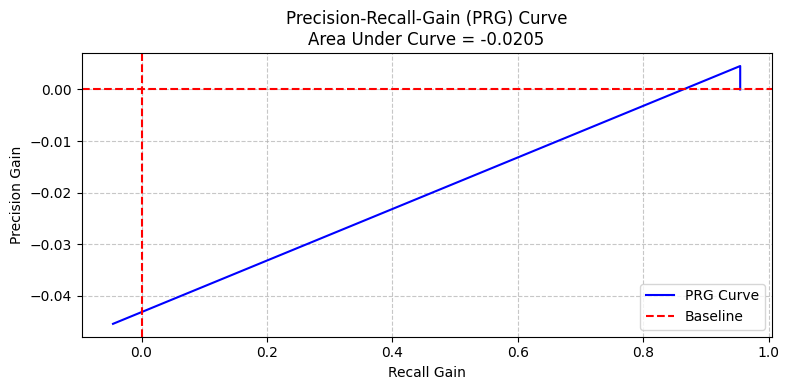

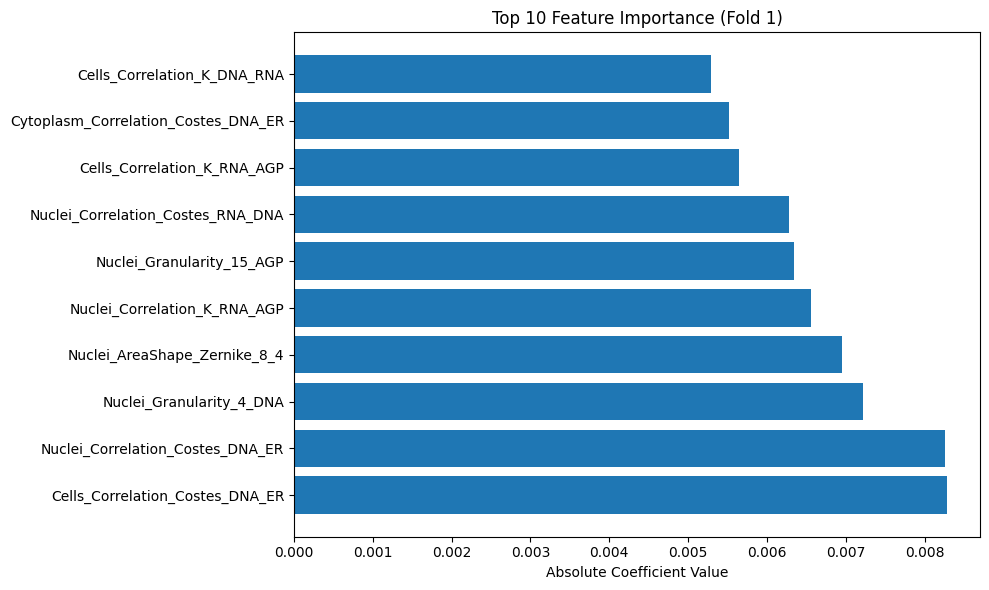

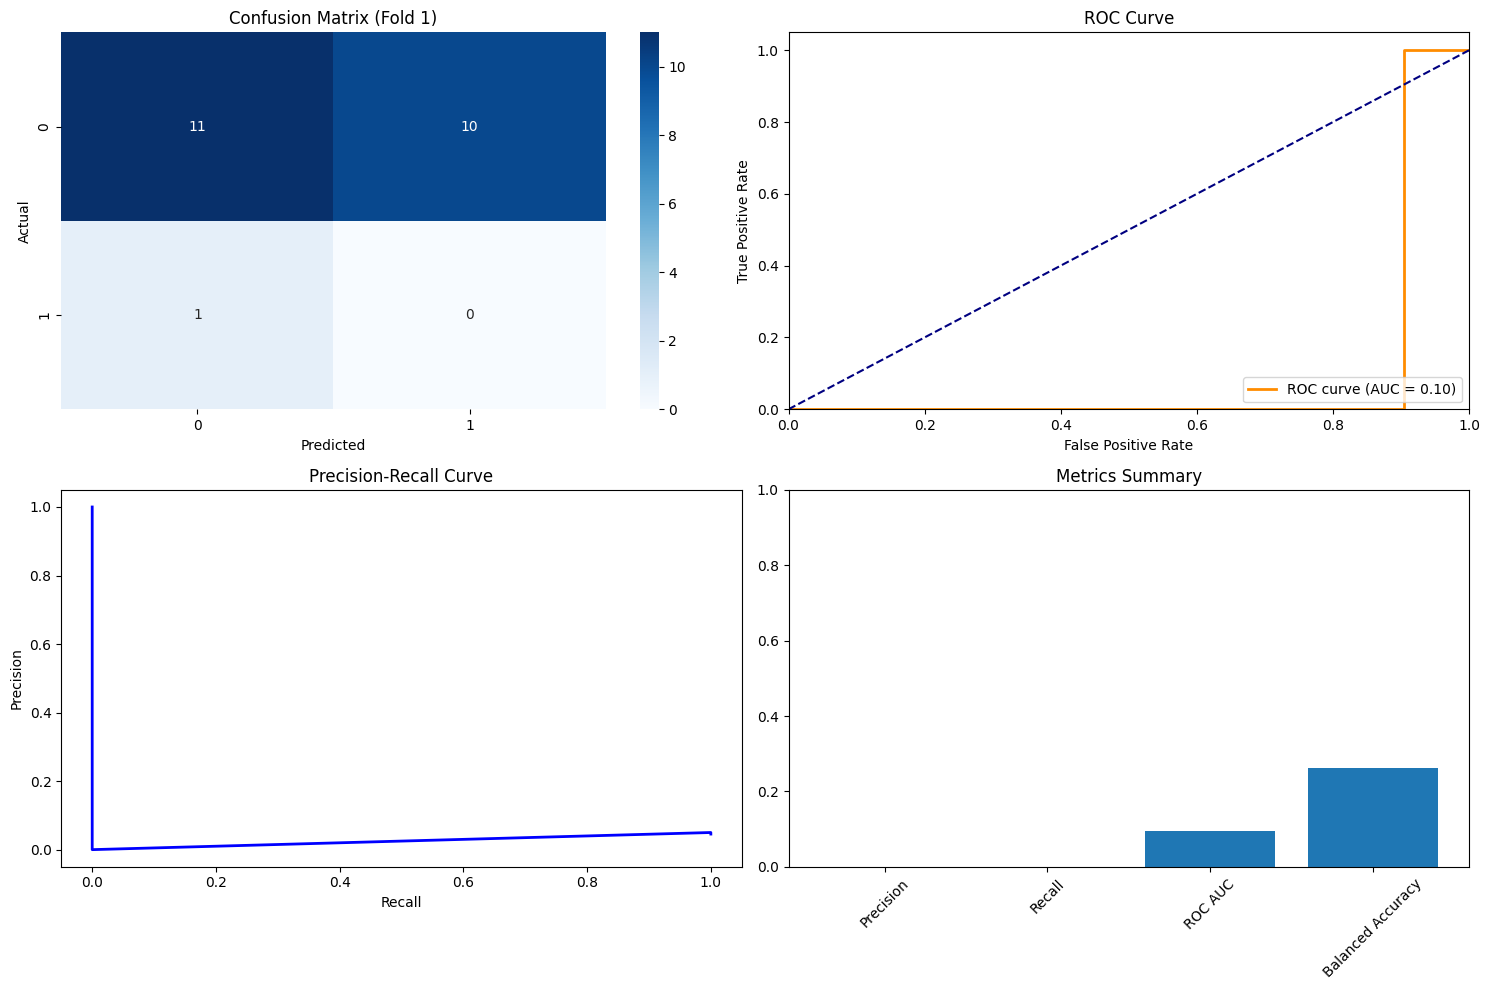


Processing fold 2/5


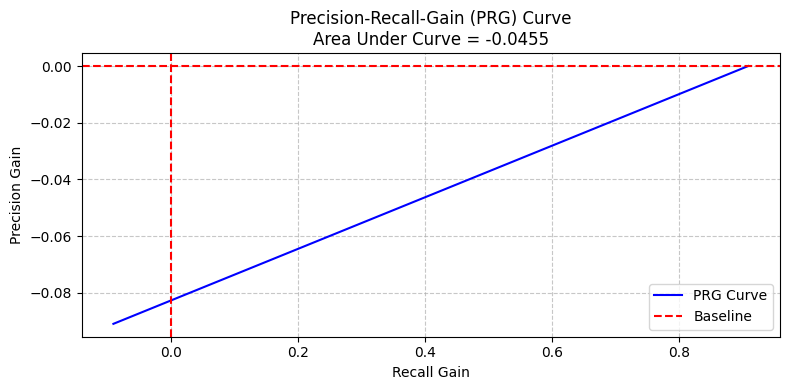

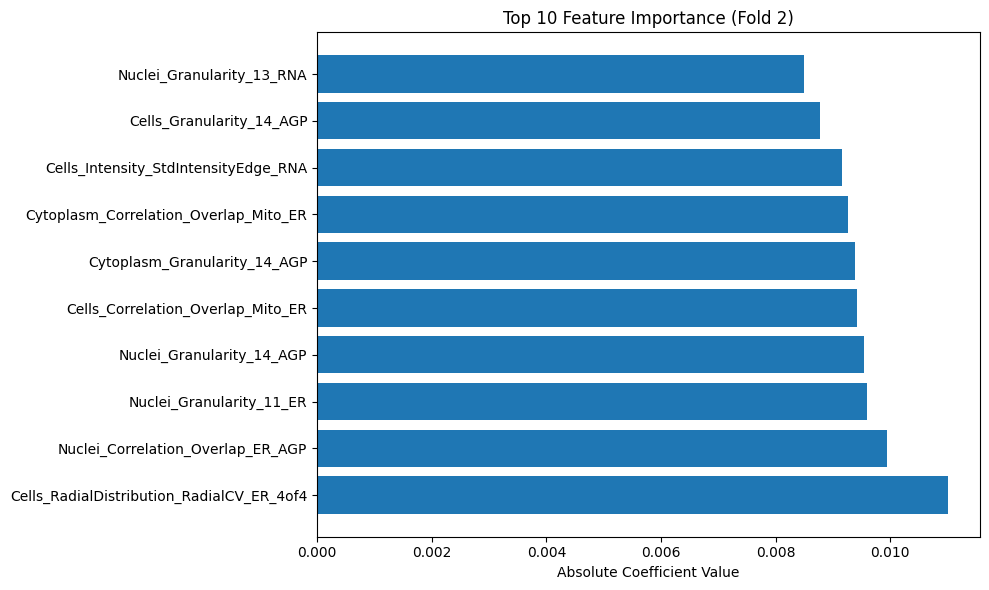

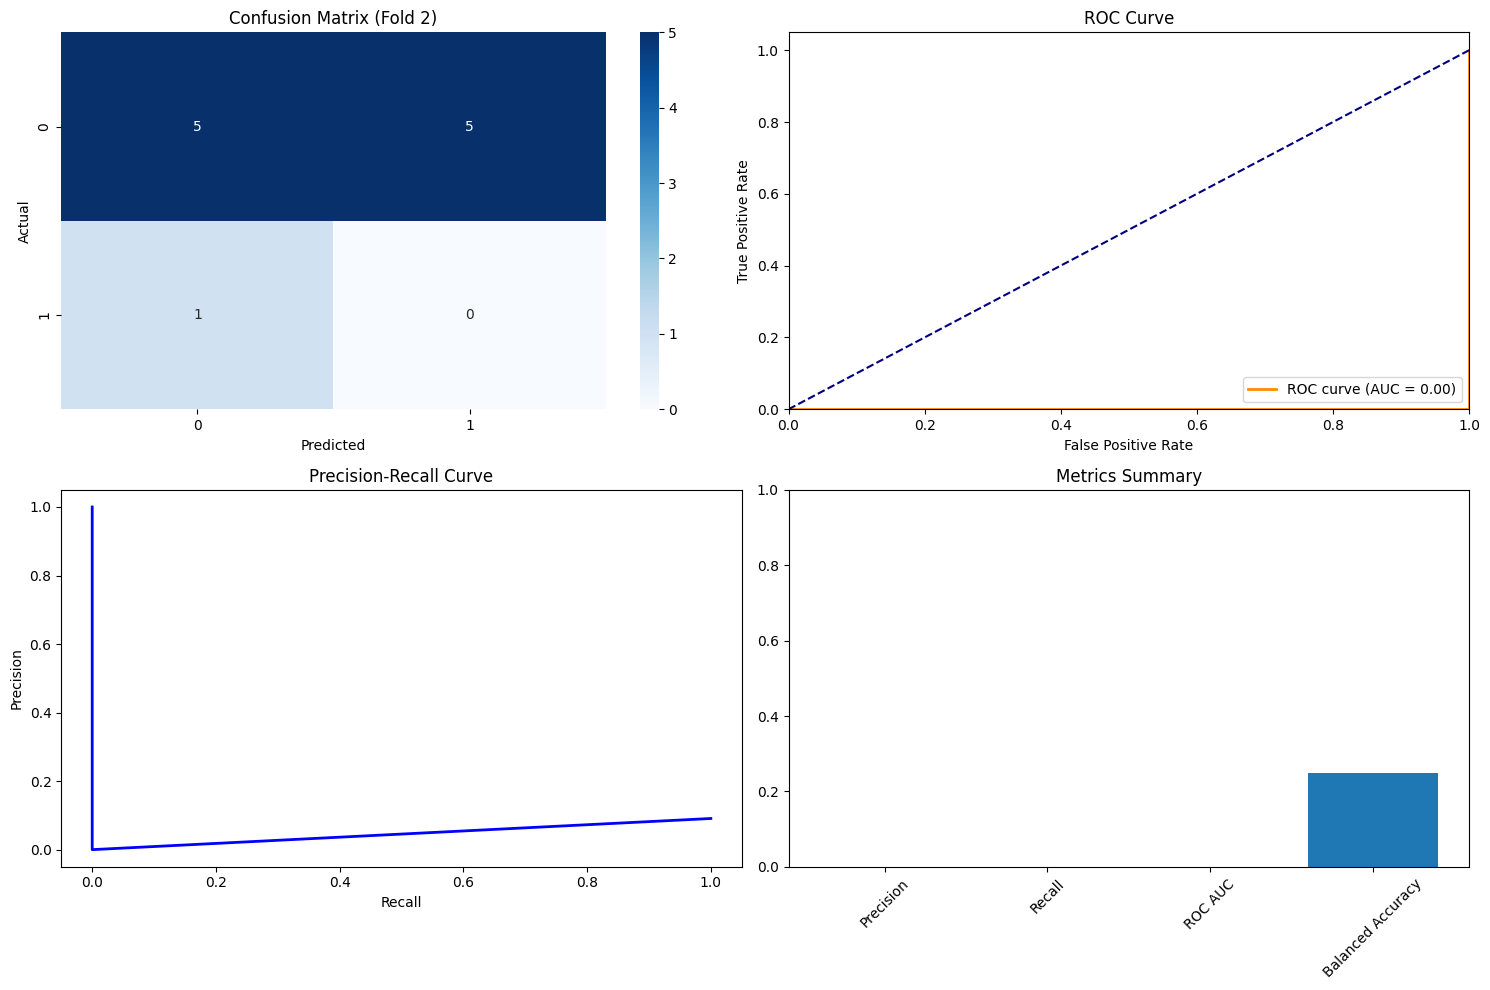


Processing fold 3/5

Processing fold 4/5


  0%|▎                                                                                 | 1/270 [00:02<11:30,  2.57s/it]


Processing fold 5/5
10_19
0.0    75
1.0     2
Name: count, dtype: int64

Processing fold 1/5

Processing fold 2/5


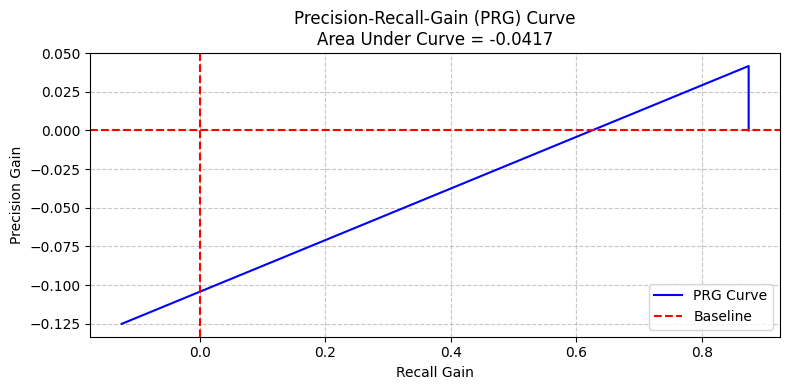

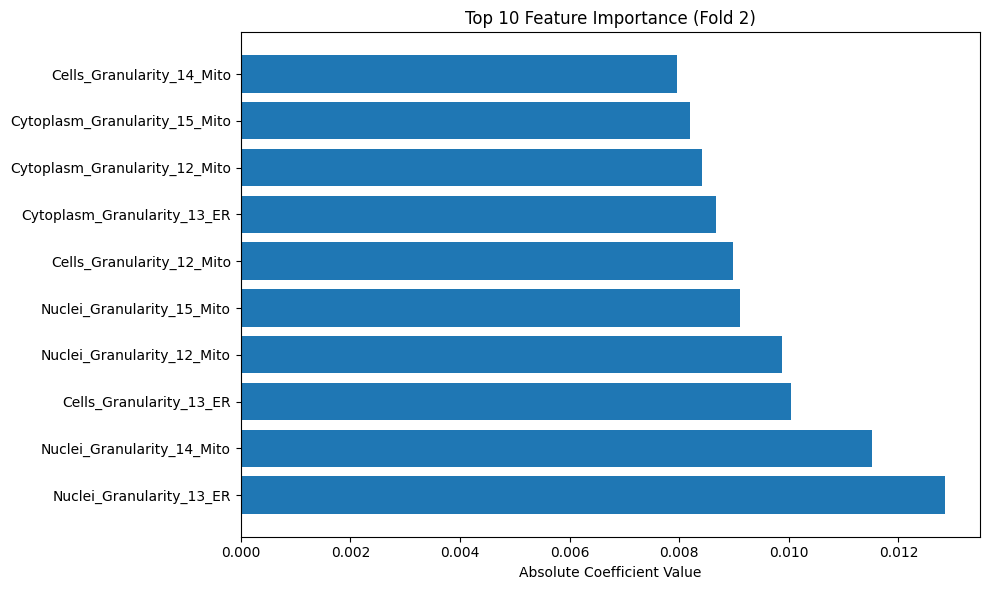

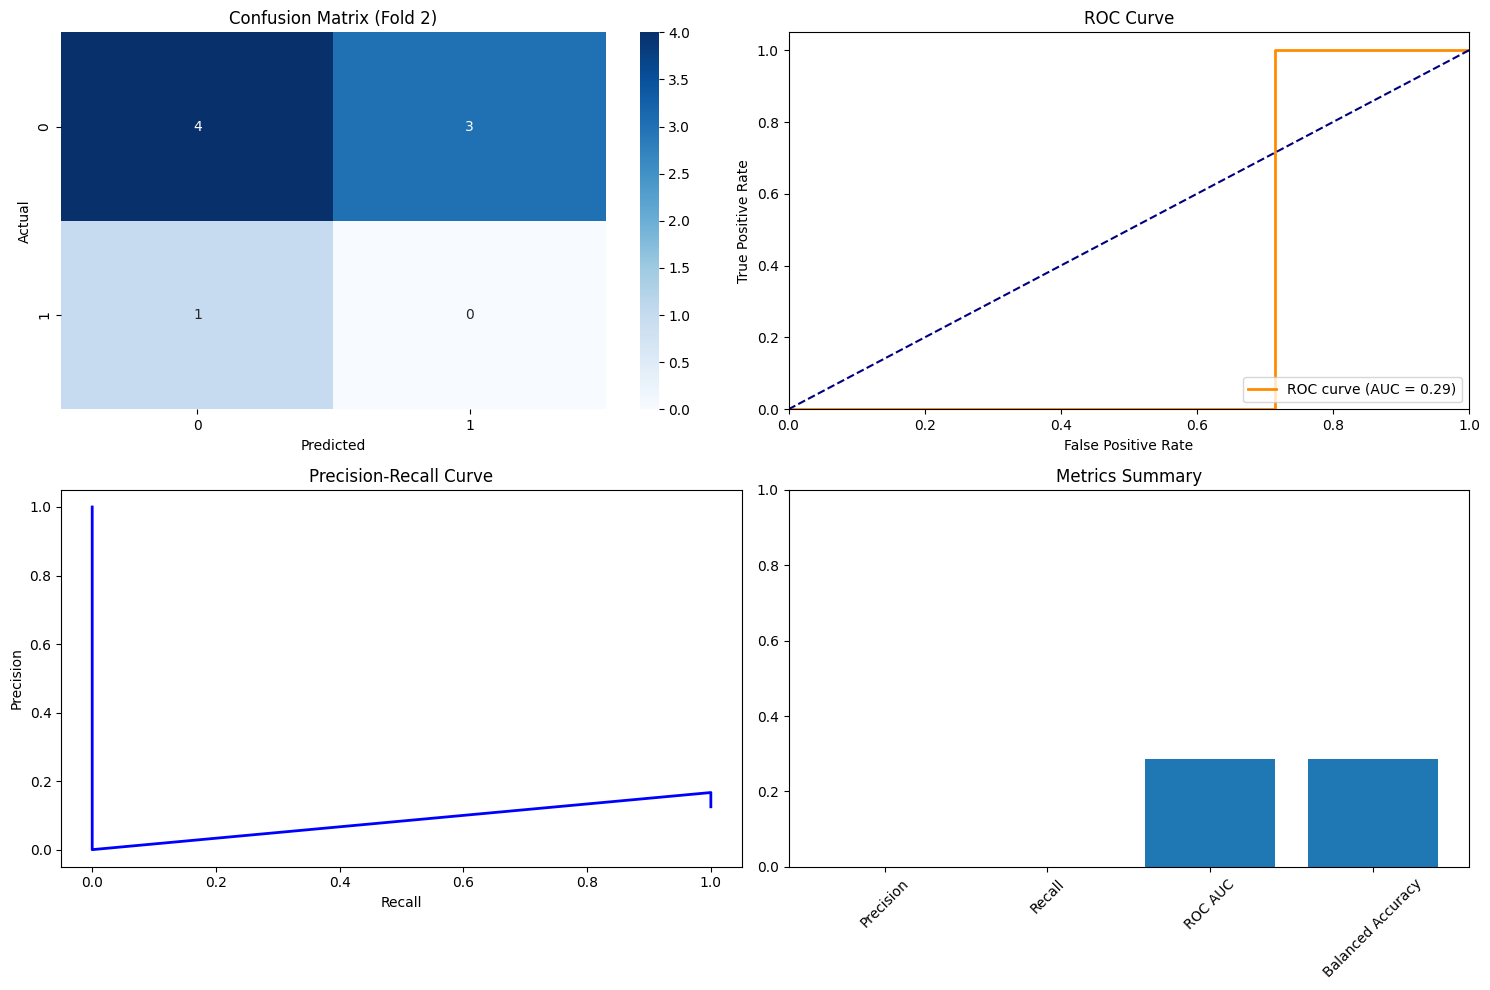


Processing fold 3/5

Processing fold 4/5

Processing fold 5/5


  0%|▎                                                                                 | 1/270 [00:04<19:07,  4.27s/it]

KeyboardInterrupt



<Figure size 800x400 with 0 Axes>

In [4]:
# !! Don't re-run unless necessary (results can be loaded below)

results_dict = {}
lack_data_ep = []

for endpoint_name in tqdm(endpoint_list): 
    
    base_model = LogisticRegression(random_state=42, 
                                C=0.001, 
                                class_weight="balanced",
                                penalty='l2',  
                                solver='liblinear',
                                max_iter=500,
                                )
    
    df_assay = cp_assay_merged.dropna(subset=[endpoint_name])
    print(df_assay[endpoint_name].value_counts())
    
    if (df_assay[endpoint_name].value_counts().get(0.0, 0) < 5.0) or \
                (df_assay[endpoint_name].value_counts().get(1.0, 0) < 5.0):
        lack_data_ep.append(endpoint_name)
        
    # Perform 5-fold CV with Moshkov's splits:
    res_df = log_regression_mkov_splits(df_assay, endpoint_name, cp_feats,
                                     base_model=base_model, res_dir=None)
    results_dict[endpoint_name] = res_df

In [161]:
# Saving list of assays with limited available data:
# pd.DataFrame(lack_data_ep, columns=["assay_id"]).to_csv("results/ltd_data_assays.csv", index=False)

# These are assays with < 5 active compounds:
print(len(lack_data_ep))

# Loading that list of limited data assays:
lack_data_ep = pd.read_csv("results/ltd_data_assays.csv").assay_id.tolist()
lack_data_ep[0:3]

85


['1_1', '10_19', '10_20']

## Cell Count Feature Only:

In [ ]:
# !! Don't re-run unless necessary (results can be loaded below)

results_dict_cell_count = {}

for endpoint_name in tqdm(endpoint_list): 
    
    base_model = LogisticRegression(random_state=42, 
                                class_weight="balanced",
                                )
    
    df_assay = cp_assay_merged.dropna(subset=[endpoint_name])
    print(df_assay[endpoint_name].value_counts())
        
    # Perform 5-fold CV with Moshkov's splits:
    res_df = log_regression_mkov_splits(df_assay, endpoint_name, cp_feats=["Cells_Number_Object_Number"],
                                     base_model=base_model, res_dir=None)
    results_dict_cell_count[endpoint_name] = res_df

## Averaging Results Across Folds:

In [98]:
def average_fold_LR_results(res_dict):
    aucs = []
    bal_accs = []
    precs = []
    recs = []
    auprcs = []
    f1_scores = []
    auprg = []
    assay = []
    failed = []

    for res in res_dict.keys():
        try:  
            aucs.append(res_dict[res][0].roc_auc.mean())
            bal_accs.append(res_dict[res][0].balanced_acc.mean())
            precs.append(res_dict[res][0].precision.mean())
            recs.append(res_dict[res][0].recall.mean())
            auprcs.append(res_dict[res][0].auprc.mean())
            f1_scores.append(res_dict[res][0].f1_score.mean())
            auprg.append(res_dict[res][0].auprg.mean())
            assay.append(res)
        except:
            # These assays were eventually exlcuded for not having enough data:
            failed.append(res)

    data = {
        "PUMA_ASSAY_ID": assay,
        "roc_auc": aucs,
        "balanced_acc": bal_accs,
        "precision": precs,
        "recall": recs,
        "auprc": auprcs, 
        "f1_score": f1_scores,
        "auprg": auprg,
        }
    df = pd.DataFrame(data)

    return df, failed

## Logistic Regression Results: Moshkov Scaffold Splits:

### All CP Features:

In [15]:
# Processing original results, generated above.
mkov_splits_df, moshkov_v_ltd_assays = average_fold_LR_results(results_dict)
mkov_splits_df.head()

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprcg
0,1_1,0.047619,0.255952,0.000000,0.000000,0.070455,0.000000,0.035714
1,10_19,0.309524,0.309524,0.000000,0.000000,0.116667,0.000000,0.030159
2,10_20,0.382212,0.563702,0.131250,0.750000,0.148214,0.201681,0.008270
3,100_277,0.753333,0.814167,0.540000,0.933333,0.611111,0.633333,-0.376111
4,100_278,0.775926,0.670238,0.493333,0.683333,0.746349,0.545714,-0.484200


In [162]:
# Saving list of assays excluded from further analysis due to lack of data:
# pd.DataFrame(moshkov_v_ltd_assays, columns=["assay_id"]).to_csv("results/exluded_assays.csv", index=False)

# Loading that list of excluded assays:
moshkov_v_ltd_assays = pd.read_csv("results/exluded_assays.csv").assay_id.tolist()
moshkov_v_ltd_assays[0:3]

['105_377', '104_295', '104_319']

In [14]:
len(moshkov_v_ltd_assays)

40

In [163]:
# Saving/ loading results dataframe:
# mkov_splits_df.to_csv("CP_All_Log_Res_Results_MkovSplits.csv", index=False)

mkov_splits_df = pd.read_csv("results/CP_All_Log_Res_Results_MkovSplits.csv")
mkov_splits_df.head()

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg
0,1_1,0.047619,0.255952,0.000000,0.000000,0.070455,0.000000,-0.032955
1,10_19,0.309524,0.309524,0.000000,0.000000,0.116667,0.000000,-0.026894
2,10_20,0.382212,0.563702,0.131250,0.750000,0.148214,0.201681,-0.008082
3,100_277,0.753333,0.814167,0.540000,0.933333,0.611111,0.633333,0.080144
4,100_278,0.775926,0.670238,0.493333,0.683333,0.746349,0.545714,0.196665


In [33]:
len(mkov_splits_df)

230

### Cell Count Feature Only:

In [99]:
# Processing original results, generated above.
mkov_splits_cc_df, _ = average_fold_LR_results(results_dict_cell_count)
mkov_splits_cc_df.head()

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg
0,1_1,0.759524,0.829762,0.180556,1.000000,0.305556,0.300000,0.084596
1,10_19,0.714286,0.821429,0.196429,1.000000,0.238095,0.325000,0.033820
2,10_20,0.509615,0.322115,0.071429,0.250000,0.350962,0.111111,0.005593
3,100_277,0.776667,0.813333,0.550000,0.866667,0.627778,0.626667,0.079589
4,100_278,0.733333,0.678571,0.693333,0.700000,0.731667,0.607619,0.198074


In [164]:
# Saving/ loading results dataframe:
# mkov_splits_cc_df.to_csv("CP_All_Log_Res_Results_CellCountOnly_MkovSplits.csv", index=False)

mkov_splits_cc_df = pd.read_csv("results/CP_All_Log_Res_Results_CellCountOnly_MkovSplits.csv")
mkov_splits_cc_df.head()

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg
0,1_1,0.759524,0.780952,0.145455,1.000000,0.305556,0.250000,0.084596
1,10_19,0.714286,0.761905,0.155556,1.000000,0.238095,0.266667,0.033820
2,10_20,0.509615,0.556490,0.107143,0.750000,0.350962,0.177778,0.005593
3,100_277,0.776667,0.783056,0.423333,0.933333,0.627778,0.546667,0.079589
4,100_278,0.733333,0.703571,0.693333,0.750000,0.731667,0.645714,0.198074


# Scatterplots of Performance:

In [19]:
# Assays are split into 3 cohorts:
print(f"There are {len(moshkov_v_ltd_assays)} assays with not enough data to have positive and negative samples in the train and test set")


moshkov_ltd_assays = list(set(lack_data_ep) - set(moshkov_v_ltd_assays))
print(f"There are {len(moshkov_ltd_assays)} assays with less than five active compounds, but enough to cross-validate at least one fold.")

mkov_adeq_assays = list(set(endpoint_list) - set(lack_data_ep))
print(f"There are {len(mkov_adeq_assays)} assays with enough data for 5-fold cross-validation.")

There are 40 assays with not enough data to have positive and negative samples in the train and test set
There are 45 assays with less than five active compounds, but enough to cross-validate at least one fold.
There are 185 assays with enough data for 5-fold cross-validation.


In [165]:
assay_meta = pd.read_csv("data/assay_metadata.csv")
print(assay_meta.shape)
assay_meta.head()

(270, 6)


,PUMA_ASSAY_ID,ASSAY_NAME,OBS_NAME,OBS_SOURCE,ASSAY_TYPE,READOUT_TYPE
0,1_1,AmyloidFormation.Absorb.AB42,BL21-DE3,ChemBank,bacterial,absorbance
1,10_19,BacterialViability.FluorProt.485/538,BCG.JP15,ChemBank,bacterial,fluorescence
2,10_20,BacterialViability.FluorProt.485/538,MTB.puv3583c,ChemBank,bacterial,fluorescence
3,100_277,KRasSyntheticLethality.Lumin.CTG,MEF285.48h,ChemBank,cell,Luminescence
4,100_278,KRasSyntheticLethality.Lumin.CTG,MEF331.48h,ChemBank,cell,Luminescence


In [21]:
def update_results_metrics(res_df, cp_data, assay_meta):
    assay_compounds = []
    assay_actives = []
    assay_names = []

    for endpoint_id in res_df.PUMA_ASSAY_ID.unique(): 
        df_assay = cp_data.dropna(subset=[endpoint_id])
        n_comps = len(df_assay[endpoint_id])
        n_act = df_assay[endpoint_id].value_counts()[1.0] 
        assay_compounds.append(n_comps)
        assay_actives.append(n_act)
        a_name = assay_meta[assay_meta["PUMA_ASSAY_ID"]==endpoint_id].ASSAY_NAME.values[0]
        assay_names.append(a_name)
        
        
    # Adding metrics to results dataframe:
    res_df["n_compounds"] = assay_compounds
    res_df["n_active"] = assay_actives
    res_df["assay_name"] = assay_names

    return res_df

## All Feature Logistic Regression:

In [94]:
all_feat_exp_metrics_df = update_results_metrics(mkov_splits_df, cp_assay_merged, assay_meta)
all_feat_exp_metrics_df.head()

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg,n_compounds,n_active,assay_name
0,1_1,0.047619,0.255952,0.000000,0.000000,0.070455,0.000000,-0.032955,100,2,AmyloidFormation.Absorb.AB42
1,10_19,0.309524,0.309524,0.000000,0.000000,0.116667,0.000000,-0.026894,77,2,BacterialViability.FluorProt.485/538
2,10_20,0.382212,0.563702,0.131250,0.750000,0.148214,0.201681,-0.008082,64,3,BacterialViability.FluorProt.485/538
3,100_277,0.753333,0.814167,0.540000,0.933333,0.611111,0.633333,0.080144,43,9,KRasSyntheticLethality.Lumin.CTG
4,100_278,0.775926,0.670238,0.493333,0.683333,0.746349,0.545714,0.196665,45,16,KRasSyntheticLethality.Lumin.CTG


In [16]:
all_feat_exp_metrics_df[all_feat_exp_metrics_df["roc_auc"]>=0.9]

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg,n_compounds,n_active,assay_name
8,105_361,0.976190,0.876190,0.588889,1.000000,0.944444,0.660606,0.060185,53,4,MODYCellProfiling.Lumin.CTG
14,104_297,0.916667,0.875000,0.583333,1.000000,0.791667,0.733333,0.083333,34,3,MODYCellProfiling.FluorDye.Resazurin
15,104_299,0.968750,0.850000,0.687500,0.750000,0.875000,0.714286,0.201389,34,7,MODYCellProfiling.FluorDye.Resazurin
18,104_323,0.941270,0.818889,0.750000,0.700000,0.833333,0.704762,0.216111,34,10,MODYCellProfiling.FluorDye.Resazurin
62,15_26,0.913399,0.729575,0.433048,0.888889,0.611111,0.435498,0.241402,62,6,BetaCateninSignaling.FluorDye.PosCellsW2_Int
63,153_510,0.900000,0.800000,0.208333,1.000000,0.666667,0.342857,0.037879,41,2,StemCellDifferentiation.ImmFluor.CellCt
64,154_511,0.962963,0.870370,0.533333,1.000000,0.861111,0.634921,0.214646,41,5,BetaCateninSignaling.FluorDye.PosCellsW2_Int
129,215_685,0.927010,0.851881,0.245070,0.873611,0.664067,0.381488,0.564511,1920,111,215_685
168,250_726,0.907592,0.840895,0.074427,0.832778,0.609024,0.134949,0.446030,3192,45,250_726
171,254_730,0.905642,0.842600,0.060298,0.867857,0.485339,0.110441,0.160841,1950,24,254_730


In [69]:
all_feat_exp_metrics_df[all_feat_exp_metrics_df["auprg"]>=0.3]

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg,n_compounds,n_active,assay_name,annotation
86,184_606,0.863903,0.800836,0.271687,0.794298,0.627802,0.402513,0.481318,952,78,184_606,None
116,202_661,0.879792,0.855615,0.093081,0.865000,0.454170,0.166449,0.346817,2434,43,MLPCN Ras selective lethality,Lethality
129,215_685,0.927010,0.851881,0.245070,0.873611,0.664067,0.381488,0.564511,1920,111,215_685,None
168,250_726,0.907592,0.840895,0.074427,0.832778,0.609024,0.134949,0.446030,3192,45,250_726,None


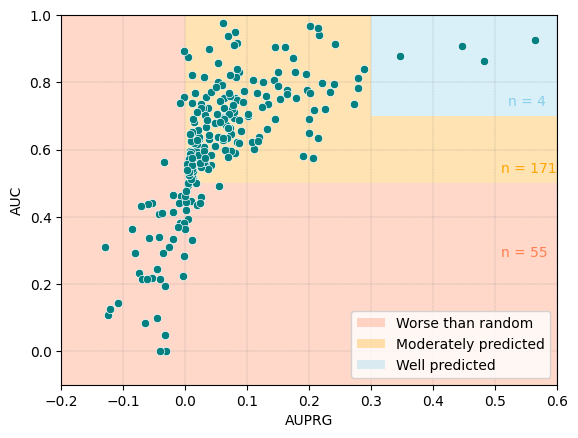

In [39]:
# Worst than random prediction region:
plt.fill_between(
    x=np.linspace(-0.2, 0, 500), 
    y1=-0.1, 
    y2=1.0, 
    color='coral', 
    alpha=0.3, 
    label="Worse than random",
    edgecolor='none'
)

plt.fill_between(
    x=np.linspace(0, 1.0, 500), 
    y1=-0.1, 
    y2=0.5, 
    color='coral', 
    alpha=0.3, 
    edgecolor='none'
)

# Moderately better than random region:
plt.fill_between(
    x=np.linspace(0, 0.6, 500), 
    y1=0.5, 
    y2=0.7, 
    color='orange', 
    alpha=0.3, 
    label="Moderately predicted",
    edgecolor='none'
)

plt.fill_between(
    x=np.linspace(0, 0.3, 500), 
    y1=0.7, 
    y2=1.0, 
    color='orange', 
    alpha=0.3, 
    edgecolor='none'
)

# Well-predicted assays:
plt.fill_between(
    x=np.linspace(0.3, 0.6, 500), 
    y1=0.7, 
    y2=1.0, 
    color='skyblue', 
    alpha=0.3, 
    label="Well predicted",
    edgecolor='none'
)

# Adding text for number of assays in each category:
well_pred = len(all_feat_exp_metrics_df[(all_feat_exp_metrics_df["roc_auc"]>0.7) & (all_feat_exp_metrics_df["auprg"]>0.3)])
mod_pred = len(all_feat_exp_metrics_df[(all_feat_exp_metrics_df["roc_auc"]>0.5) & (all_feat_exp_metrics_df["auprg"]>0.0)])-well_pred
poor_pred = len(all_feat_exp_metrics_df)-mod_pred-well_pred

plt.text(x=0.52, y=0.73, s=f"n = {well_pred}", c="skyblue")
plt.text(x=0.51, y=0.53, s=f"n = {mod_pred}", c="orange")
plt.text(x=0.51, y=0.28, s=f"n = {poor_pred}", c="coral")

sns.scatterplot(data=all_feat_exp_metrics_df, x='auprg', y='roc_auc', c="teal")
plt.xlabel("AUPRG")
plt.ylabel("AUC")

plt.grid(visible=True, color='grey', linestyle='--', linewidth=0.2)
plt.ylim(-0.1, 1)
plt.xlim(-.2, 0.6)

plt.show()

## Cell Count Only Logistic Regression:

In [41]:
cc_feat_exp_metrics_df = update_results_metrics(mkov_splits_cc_df, cp_assay_merged, assay_meta)
cc_feat_exp_metrics_df.head()

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg,n_compounds,n_active,assay_name
0,1_1,0.759524,0.780952,0.145455,1.000000,0.305556,0.250000,0.084596,100,2,AmyloidFormation.Absorb.AB42
1,10_19,0.714286,0.761905,0.155556,1.000000,0.238095,0.266667,0.033820,77,2,BacterialViability.FluorProt.485/538
2,10_20,0.509615,0.556490,0.107143,0.750000,0.350962,0.177778,0.005593,64,3,BacterialViability.FluorProt.485/538
3,100_277,0.776667,0.783056,0.423333,0.933333,0.627778,0.546667,0.079589,43,9,KRasSyntheticLethality.Lumin.CTG
4,100_278,0.733333,0.703571,0.693333,0.750000,0.731667,0.645714,0.198074,45,16,KRasSyntheticLethality.Lumin.CTG


In [42]:
cc_feat_exp_metrics_df[cc_feat_exp_metrics_df["roc_auc"]>=0.9]

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg,n_compounds,n_active,assay_name
13,104_325,0.958333,0.656944,0.333333,0.666667,0.833333,0.444444,0.185185,34,5,MODYCellProfiling.FluorDye.Resazurin
14,104_297,0.958333,0.750000,0.416667,1.000000,0.916667,0.583333,0.083333,34,3,MODYCellProfiling.FluorDye.Resazurin
15,104_299,0.937500,0.721875,0.500000,0.750000,0.833333,0.583333,0.180556,34,7,MODYCellProfiling.FluorDye.Resazurin
18,104_323,0.985714,0.856667,0.750000,0.900000,0.966667,0.746667,0.202778,34,10,MODYCellProfiling.FluorDye.Resazurin
62,15_26,0.905229,0.745098,0.316667,1.000000,0.638889,0.443939,0.222884,62,6,BetaCateninSignaling.FluorDye.PosCellsW2_Int
64,154_511,0.925926,0.796296,0.472222,1.000000,0.805556,0.561905,0.172980,41,5,BetaCateninSignaling.FluorDye.PosCellsW2_Int
82,18_29,0.955357,0.863095,0.589583,1.000000,0.877778,0.710165,0.284040,62,12,BetaCateninSignaling.FluorDye.TotalNuclei
115,201_660,0.904715,0.775491,0.143658,0.791667,0.454911,0.231397,0.200434,274,10,201_660
171,254_730,0.930721,0.841574,0.047466,0.946429,0.219753,0.089429,0.148412,1950,24,254_730
201,3_3,0.908333,0.829167,0.321429,1.000000,0.500000,0.458333,0.166084,41,2,AndrogenSignaling.FluorDye.DAPI


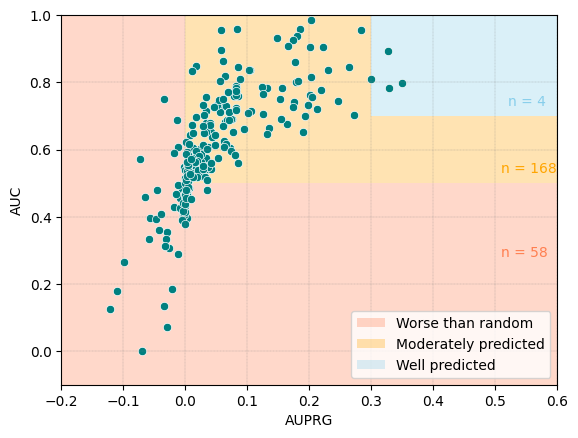

In [44]:
# Worst than random prediction region:
plt.fill_between(
    x=np.linspace(-0.2, 0, 500), 
    y1=-0.1, 
    y2=1.0, 
    color='coral', 
    alpha=0.3, 
    label="Worse than random",
    edgecolor='none'
)

plt.fill_between(
    x=np.linspace(0, 1.0, 500), 
    y1=-0.1, 
    y2=0.5, 
    color='coral', 
    alpha=0.3, 
    edgecolor='none'
)

# Moderately better than random region:
plt.fill_between(
    x=np.linspace(0, 0.6, 500), 
    y1=0.5, 
    y2=0.7, 
    color='orange', 
    alpha=0.3, 
    label="Moderately predicted",
    edgecolor='none'
)

plt.fill_between(
    x=np.linspace(0, 0.3, 500), 
    y1=0.7, 
    y2=1.0, 
    color='orange', 
    alpha=0.3, 
    edgecolor='none'
)

# Well-predicted assays:
plt.fill_between(
    x=np.linspace(0.3, 0.6, 500), 
    y1=0.7, 
    y2=1.0, 
    color='skyblue', 
    alpha=0.3, 
    label="Well predicted",
    edgecolor='none'
)

# Adding text for number of assays in each category:
well_pred = len(cc_feat_exp_metrics_df[(cc_feat_exp_metrics_df["roc_auc"]>0.7) & (cc_feat_exp_metrics_df["auprg"]>0.3)])
mod_pred = len(cc_feat_exp_metrics_df[(cc_feat_exp_metrics_df["roc_auc"]>0.5) & (cc_feat_exp_metrics_df["auprg"]>0.0)])-well_pred
poor_pred = len(cc_feat_exp_metrics_df)-mod_pred-well_pred

plt.text(x=0.52, y=0.73, s=f"n = {well_pred}", c="skyblue")
plt.text(x=0.51, y=0.53, s=f"n = {mod_pred}", c="orange")
plt.text(x=0.51, y=0.28, s=f"n = {poor_pred}", c="coral")

sns.scatterplot(data=cc_feat_exp_metrics_df, x='auprg', y='roc_auc', c="teal")
plt.xlabel("AUPRG")
plt.ylabel("AUC")

plt.grid(visible=True, color='grey', linestyle='--', linewidth=0.2)
plt.ylim(-0.1, 1)
plt.xlim(-.2, 0.6)

plt.show()

## Isolating Specific Types of Endpoints:

### All Features:

In [139]:
all_feat_exp_metrics_df['annotation'] = np.select(
    [
        all_feat_exp_metrics_df['assay_name'].str.contains("Resazurin", case=False),
#         all_feat_exp_metrics_df['assay_name'].str.contains("Lethality", case=False),
        all_feat_exp_metrics_df['assay_name'].str.contains("BetaCatenin", case=False),
    ],
    ["Resazurin", "BetaCatenin"], #"Lethality", 
    default="None")

In [140]:
all_feat_exp_metrics_df.head(3)

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg,n_compounds,n_active,assay_name,annotation
0,1_1,0.047619,0.255952,0.00000,0.00,0.070455,0.000000,-0.032955,100,2,AmyloidFormation.Absorb.AB42,None
1,10_19,0.309524,0.309524,0.00000,0.00,0.116667,0.000000,-0.026894,77,2,BacterialViability.FluorProt.485/538,None
2,10_20,0.382212,0.563702,0.13125,0.75,0.148214,0.201681,-0.008082,64,3,BacterialViability.FluorProt.485/538,None


In [141]:
all_feat_exp_metrics_df[all_feat_exp_metrics_df["annotation"]=="Lethality"]

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg,n_compounds,n_active,assay_name,annotation


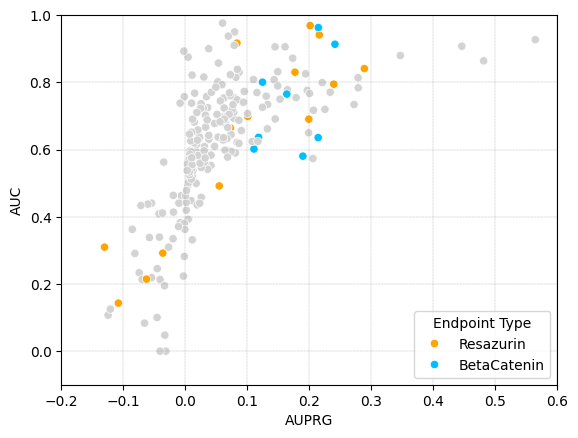

In [142]:
palette = {
#     "Lethality": "orchid",
    "Resazurin": "orange",
    "BetaCatenin": "deepskyblue",
    "None": "lightgrey"
}

sns.scatterplot(data=all_feat_exp_metrics_df, x='auprg', y='roc_auc', hue='annotation', palette=palette)
plt.xlabel("AUPRG")
plt.ylabel("AUC")

plt.grid(visible=True, color='grey', linestyle='--', linewidth=0.2)
plt.ylim(-0.1, 1)
plt.xlim(-0.2, 0.6)

# Removing "None" annotation from label:
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l != "None"]
handles, labels = zip(*filtered_handles_labels)
plt.legend(handles, labels, title="Endpoint Type")

plt.show()

### Cell Count Baseline:

In [143]:
cc_feat_exp_metrics_df['annotation'] = np.select(
    [    
        cc_feat_exp_metrics_df['assay_name'].str.contains("Resazurin", case=False),
#         cc_feat_exp_metrics_df['assay_name'].str.contains("Lethality", case=False),
        cc_feat_exp_metrics_df['assay_name'].str.contains("BetaCatenin", case=False),
    ],
    ["Resazurin", "BetaCatenin"], #"Lethality", 
    default="None")
cc_feat_exp_metrics_df.head(3)

,PUMA_ASSAY_ID,roc_auc,balanced_acc,precision,recall,auprc,f1_score,auprg,n_compounds,n_active,assay_name,annotation
0,1_1,0.759524,0.780952,0.145455,1.00,0.305556,0.250000,0.084596,100,2,AmyloidFormation.Absorb.AB42,None
1,10_19,0.714286,0.761905,0.155556,1.00,0.238095,0.266667,0.033820,77,2,BacterialViability.FluorProt.485/538,None
2,10_20,0.509615,0.556490,0.107143,0.75,0.350962,0.177778,0.005593,64,3,BacterialViability.FluorProt.485/538,None


In [149]:
len(cc_feat_exp_metrics_df[~(cc_feat_exp_metrics_df["annotation"]=="None")])

22

In [151]:
cc_feat_exp_metrics_df[~(cc_feat_exp_metrics_df["annotation"]=="None")].roc_auc.mean()

0.8062001565249699

In [152]:
cc_feat_exp_metrics_df[~(cc_feat_exp_metrics_df["annotation"]=="None")].auprg.mean()

0.15418195563012854

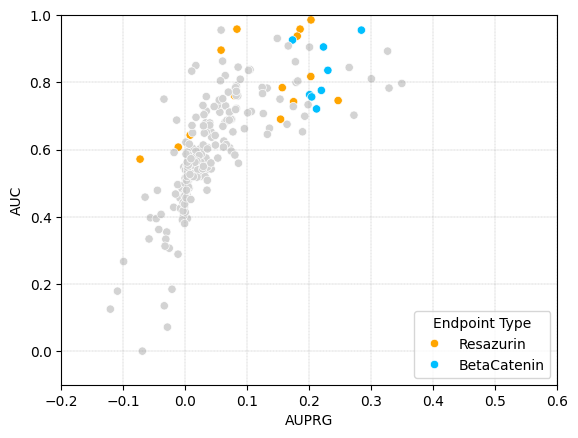

In [144]:
sns.scatterplot(data=cc_feat_exp_metrics_df, x='auprg', y='roc_auc', hue='annotation', palette=palette)
plt.xlabel("AUPRG")
plt.ylabel("AUC")

plt.grid(visible=True, color='grey', linestyle='--', linewidth=0.2)
plt.ylim(-0.1, 1)
plt.xlim(-0.2, 0.6)

# Removing "None" annotation from label:
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l != "None"]
handles, labels = zip(*filtered_handles_labels)
plt.legend(handles, labels, title="Endpoint Type", loc="lower right")

plt.show()

# Count of Data Imbalance:

In [63]:
data_imbalance = []

for endpoint_name in tqdm(endpoint_list): 
    
    df_assay = cp_assay_merged.dropna(subset=[endpoint_name])
    imbalance = df_assay[endpoint_name].value_counts()[0]/ df_assay[endpoint_name].value_counts()[1]
    data_imbalance.append(imbalance)

100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:04<00:00, 61.64it/s]


In [66]:
print("Maximum data imbalance: ", max(data_imbalance))
print("Minimum data imbalance: ", min(data_imbalance))

Maximum data imbalance:  981.0
Minimum data imbalance:  1.0476190476190477


In [68]:
print("Number of assays with >5x more inactive compounds: ", len([x for x in data_imbalance if x>=5.0]))
print("Number of assays with >10x more inactive compounds: ", len([x for x in data_imbalance if x>=10.0]))

Number of assays with >5x more inactive compounds:  232
Number of assays with >10x more inactive compounds:  185


# Density/ Bar Plots of Results:

In [66]:
def plot_KDE(data, palette, metric, xlim=(0.4, 1.0), title=None):
    # Create figure
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="white")

    df = pd.DataFrame(data)
    df_long = df.melt(var_name='Model', value_name=metric)

    # Create KDE plots for each model
    for model in data.keys():
        model_data = df_long[df_long['Model'] == model]
        sns.kdeplot(data=model_data, 
                    x=metric,
                    label=model,
                    color=my_pal[model],
                    fill=True,
                    alpha=0.3)

#         # Add scatter points along the x-axis
#         plt.scatter(model_data[metric], 
#                    np.zeros_like(model_data[metric]) - 0.2,  # Slight offset below x-axis
#                    color=my_pal[model],
#                    alpha=0.4,
#                    s=20)

    # Customize the plot
    plt.xlim(xlim)
    plt.xlabel(f'{metric}')
    plt.ylabel('Density')
    
    if title:
        plt.title(title)

    # Add grid lines
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Remove top and right spines
    sns.despine()

    # Adjust legend
    plt.legend(title='Approach')

    plt.tight_layout()
    plt.show()

In [43]:
def plot_histograms(data, palette, metric, xlim=(0.4, 1.0), bins=20, title=None):
    # Create figure
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="white")
    
    # Calculate histograms for each model
    n_bins = bins
    bin_edges = np.linspace(xlim[0], xlim[1], n_bins + 1)
    bin_width = (xlim[1] - xlim[0]) / n_bins
    
    # Calculate number of models and bar width
    n_models = len(data.keys())
    bar_width = bin_width / (n_models + 0.2)  # Add small gap between groups
    
    # Create bars for each model
    for idx, (model_name, model_data) in enumerate(data.items()):
        # Calculate histogram
        counts, _ = np.histogram(model_data, bins=bin_edges)
        
        # Calculate bar positions
        bar_positions = bin_edges[:-1] + idx * bar_width
        
        # Plot bars
        plt.bar(bar_positions, 
                counts,
                width=bar_width,
                label=model_name,
                color=palette[model_name],
                alpha=0.7)
    
    # Customize the plot
    plt.xlim(xlim)
    plt.xlabel(f'{metric}')
    plt.ylabel('Assay Count')
    if title:
        plt.title(title)
    
    # Add grid lines
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Remove top and right spines
    sns.despine()
    
    # Adjust legend
    plt.legend(title='Approach')
    
    plt.tight_layout()
    plt.show()

# Moshkov Paper Results:

In [166]:
moshkov_res = pd.read_csv("data/2023_Moshkov_Results.csv")
moshkov_res.head(3)

,assay_id,auc,descriptor,auc_50,auc_70,auc_90
0,1_1,0.452381,late_fusion_cs_ge,False,False,False
1,10_19,0.523810,late_fusion_cs_ge,True,False,False
2,10_20,0.370192,late_fusion_cs_ge,False,False,False


### Fusion Improvement versus Chemical Structures Alone:
- Inspecting the improvement Moshkov's triple modality fusion approach gained versus using just chemical structures. Result quoted in main text.

In [113]:
moshkov_res["descriptor"].unique()

array(['late_fusion_cs_ge', 'late_fusion_cs_ge_mobc',
       'late_fusion_cs_mobc', 'late_fusion_ge_mobc', 'cpcl_es_op',
       'cp_es_op', 'ges_es_op', 'ge_cp_es_op', 'ge_es_op',
       'ge_mobc_cp_es_op', 'ge_mobc_es_op', 'ge_mo_cp_es_op',
       'ge_mo_es_op', 'mobc_cp_es_op', 'mobc_es_op', 'mo_cp_es_op',
       'mo_es_op'], dtype=object)

In [6]:
impr_count = 0

for i in moshkov_res.assay_id.unique():
    # Return the auc for the fusion model:
    modality = "late_fusion_cs_ge_mobc"
    fusion_auc = moshkov_res[(moshkov_res["assay_id"]==i) &
                           (moshkov_res["descriptor"]==modality)].auc.values[0]
    
    # Return the auc for the chemical structure model:
    modality = "cpcl_es_op"
    cs_auc = moshkov_res[(moshkov_res["assay_id"]==i) &
                           (moshkov_res["descriptor"]==modality)].auc.values[0]
    
    # If fusion improved the prediction, increment the count:
    if fusion_auc > cs_auc:
        impr_count += 1
        
# Calculate the % of assays improved by fusing modalities, versus using chemical structure alone:
perc_imp = impr_count/ len(moshkov_res.assay_id.unique())
print(f"% assays improved by fusion: {perc_imp} % ({impr_count}/{len(moshkov_res.assay_id.unique())})")

% assays improved by fusion: 0.6185185185185185 % (167/270)


## Assay Subset Results:

In [123]:
modality = "late_fusion_cs_ge_mobc"

### Very Limited Data Subset:

In [72]:
# Extract the results for using Cell Painting data only:
v_ltd_mkov_auc = []
for i in moshkov_v_ltd_assays:
    # Return the auc for the Moshkov model for a particular assay:
    auc = moshkov_res[(moshkov_res["assay_id"]==i) &
                           (moshkov_res["descriptor"]==modality)].auc.values[0]
    v_ltd_mkov_auc.append(auc)

### Limited Data Subset:

In [73]:
ltd_mkov_auc = []
for i in moshkov_ltd_assays:
    # Return the auc for the Moshkov model for a particular assay:
    auc = moshkov_res[(moshkov_res["assay_id"]==i) &
                           (moshkov_res["descriptor"]==modality)].auc.values[0]
    ltd_mkov_auc.append(auc)

### Adequate Data Subset:

In [74]:
adeq_mkov_auc = []
for i in mkov_adeq_assays:
    # Return the auc for the Moshkov model for a particular assay:
    auc = moshkov_res[(moshkov_res["assay_id"]==i) &
                           (moshkov_res["descriptor"]==modality)].auc.values[0]
    adeq_mkov_auc.append(auc)

## 230 Included Assays:

- Results for the 230 assays included in Table 3 of the main report:

In [108]:
# Combining the assay subsets with limited data (n=45) and adequate data (n=180):
assays_incl = moshkov_ltd_assays + mkov_adeq_assays
len(assays_incl)

230

In [116]:
print(f"----- Modality: {modality} -----")

incl_assays_auc90 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_90"].sum()
print(f">0.9 AUC: {incl_assays_auc90}")
                                   
incl_assays_auc70 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_70"].sum()
print(f">0.7 AUC: {incl_assays_auc70}")
                                    
incl_assays_auc50 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_50"].sum()
print(f">0.5 AUC: {incl_assays_auc50}")

----- Modality: mobc_es_op -----
>0.9 AUC: 9
>0.7 AUC: 84
>0.5 AUC: 189


In [120]:
print(f"----- Modality: {modality} -----")

incl_assays_auc90 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_90"].sum()
print(f">0.9 AUC: {incl_assays_auc90}")
                                   
incl_assays_auc70 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_70"].sum()
print(f">0.7 AUC: {incl_assays_auc70}")
                                    
incl_assays_auc50 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_50"].sum()
print(f">0.5 AUC: {incl_assays_auc50}")

----- Modality: late_fusion_cs_mobc -----
>0.9 AUC: 13
>0.7 AUC: 99
>0.5 AUC: 190


In [122]:
print(f"----- Modality: {modality} -----")

incl_assays_auc90 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_90"].sum()
print(f">0.9 AUC: {incl_assays_auc90}")
                                   
incl_assays_auc70 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_70"].sum()
print(f">0.7 AUC: {incl_assays_auc70}")
                                    
incl_assays_auc50 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_50"].sum()
print(f">0.5 AUC: {incl_assays_auc50}")

----- Modality: late_fusion_ge_mobc -----
>0.9 AUC: 10
>0.7 AUC: 89
>0.5 AUC: 196


In [124]:
print(f"----- Modality: {modality} -----")

incl_assays_auc90 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_90"].sum()
print(f">0.9 AUC: {incl_assays_auc90}")
                                   
incl_assays_auc70 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_70"].sum()
print(f">0.7 AUC: {incl_assays_auc70}")
                                    
incl_assays_auc50 = moshkov_res[(moshkov_res["assay_id"].isin(assays_incl)) & 
                                (moshkov_res["descriptor"] == modality)]["auc_50"].sum()
print(f">0.5 AUC: {incl_assays_auc50}")

----- Modality: late_fusion_cs_ge_mobc -----
>0.9 AUC: 10
>0.7 AUC: 94
>0.5 AUC: 195


## 40 excluded assays:
- Returning the performance Moshkov obtained for the 40 assays we excluded due to a lack of data.

In [125]:
modality = "mobc_es_op"

In [127]:
print(f"----- Modality: {modality} -----")

excl_assays_auc1 = len(moshkov_res[moshkov_res["assay_id"].isin(moshkov_v_ltd_assays) &
                           (moshkov_res["descriptor"]==modality) &
                           (moshkov_res["auc"]==1.0)])
print(f"AUC = 1.0: {excl_assays_auc1}")
excl_assays_auc90 = moshkov_res[moshkov_res["assay_id"].isin(moshkov_v_ltd_assays)&
                           (moshkov_res["descriptor"]==modality)].auc_90.sum()
print(f">0.9 AUC: {excl_assays_auc90}")
excl_assays_auc70 = moshkov_res[moshkov_res["assay_id"].isin(moshkov_v_ltd_assays)&
                           (moshkov_res["descriptor"]==modality)].auc_70.sum()
print(f">0.7 AUC: {excl_assays_auc70}")

----- Modality: mobc_es_op -----
AUC = 1.0: 9
>0.9 AUC: 9
>0.7 AUC: 16


In [124]:
print(f"----- Modality: {modality} -----")

excl_assays_auc1 = len(moshkov_res[moshkov_res["assay_id"].isin(moshkov_v_ltd_assays) &
                           (moshkov_res["descriptor"]==modality) &
                           (moshkov_res["auc"]==1.0)])
print(f"AUC = 1.0: {excl_assays_auc1}")
excl_assays_auc90 = moshkov_res[moshkov_res["assay_id"].isin(moshkov_v_ltd_assays)&
                           (moshkov_res["descriptor"]==modality)].auc_90.sum()
print(f">0.9 AUC: {excl_assays_auc90}")
excl_assays_auc70 = moshkov_res[moshkov_res["assay_id"].isin(moshkov_v_ltd_assays)&
                           (moshkov_res["descriptor"]==modality)].auc_70.sum()
print(f">0.7 AUC: {excl_assays_auc70}")

----- Modality: late_fusion_cs_ge_mobc -----
AUC = 1.0: 7
>0.9 AUC: 7
>0.7 AUC: 17


# Filter LR Results - All Features:

In [25]:
lr_ltd_assays = mkov_splits_df[mkov_splits_df["PUMA_ASSAY_ID"].isin(moshkov_ltd_assays)]
lr_ltd_assays.shape

(45, 8)

In [26]:
lr_adeq_assays = mkov_splits_df[mkov_splits_df["PUMA_ASSAY_ID"].isin(mkov_adeq_assays)]
lr_adeq_assays.shape

(185, 8)

# Filter LR Results - Cell Count Feature Only:

In [27]:
lr_ltd_assays_cc = mkov_splits_cc_df[mkov_splits_cc_df["PUMA_ASSAY_ID"].isin(moshkov_ltd_assays)]
lr_ltd_assays_cc.shape

(45, 8)

In [28]:
lr_adeq_assays_cc = mkov_splits_cc_df[mkov_splits_cc_df["PUMA_ASSAY_ID"].isin(mkov_adeq_assays)]
lr_adeq_assays_cc.shape

(185, 8)

### Assays with >5 Active Compounds (n=185):

In [75]:
label1 = 'Multi-task Neural Network - Moshkov (2023)'
label2 = 'Logistic Regression - All Features'
label3 = 'Logistic Regression - Cell Count'

data = {
    label1 : np.array(adeq_mkov_auc),
    label2: lr_adeq_assays.roc_auc.values,
    label3: lr_adeq_assays_cc.roc_auc.values,
}
my_pal = {label1: "m", label2: "orange", label3: "skyblue"}

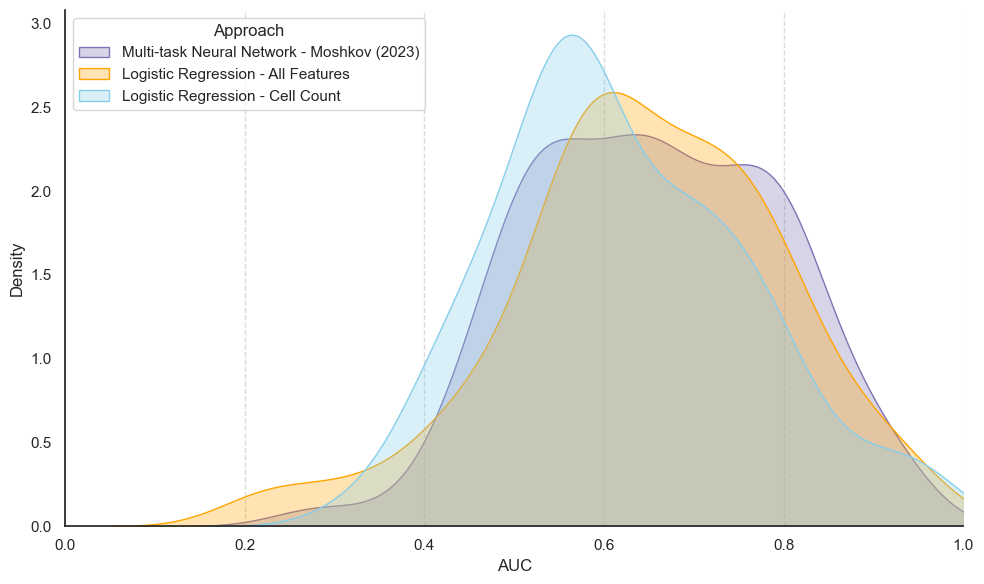

In [76]:
plot_KDE(data, my_pal, "AUC", (0.0, 1.0), title=None)

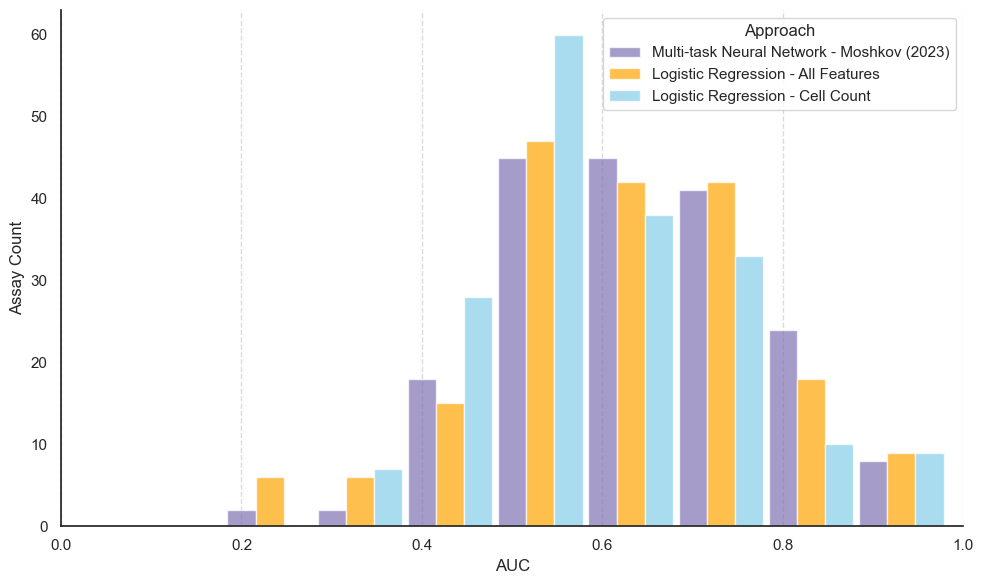

In [79]:
plot_histograms(data, my_pal, "AUC", xlim=(0.0, 1.0), bins=10, title=None)

### Assays with < 5 Active Compounds, but enough for at least one fold CV (n=45):

In [77]:
data_ltd = {
    label1 : np.array(ltd_mkov_auc),
    label2: lr_ltd_assays.roc_auc.values,
    label3: lr_ltd_assays_cc.roc_auc.values
}

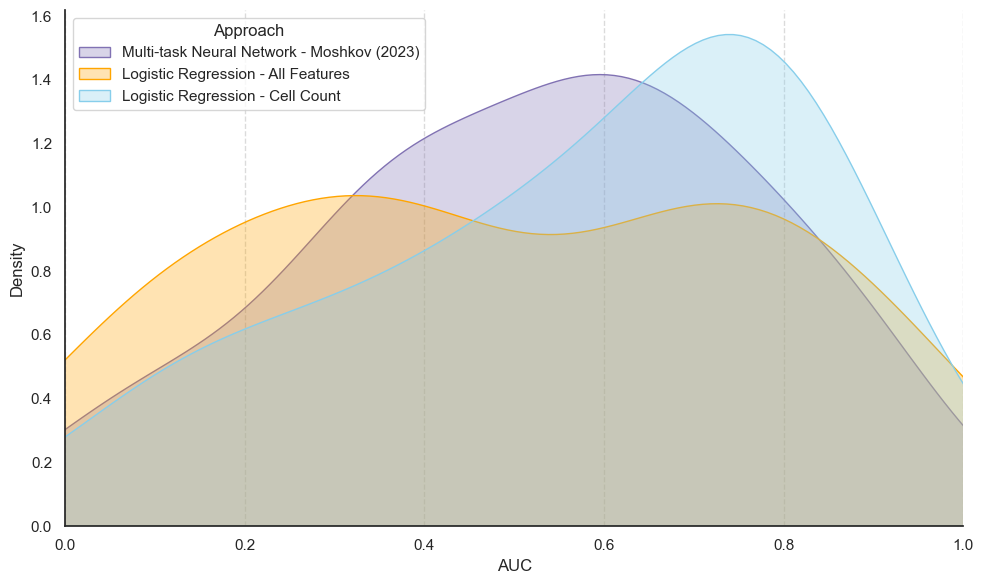

In [78]:
plot_KDE(data_ltd, my_pal, "AUC", (0.0, 1.0), title=None)

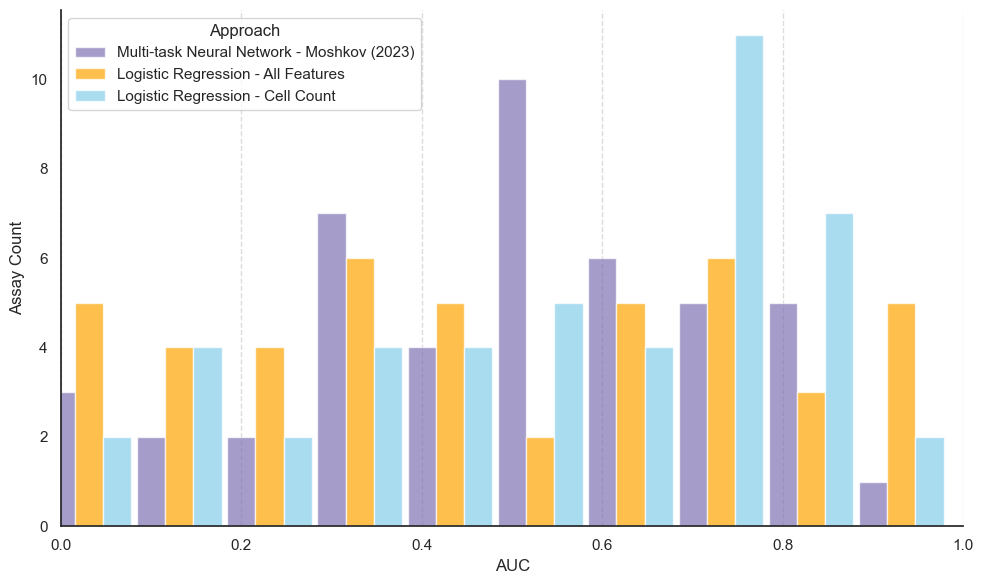

In [80]:
plot_histograms(data_ltd, my_pal, "AUC", xlim=(0.0, 1.0), bins=10, title=None)

## Assays which have been excluded:

In [82]:
data_excl = {
    label1 : np.array(v_ltd_mkov_auc),
}

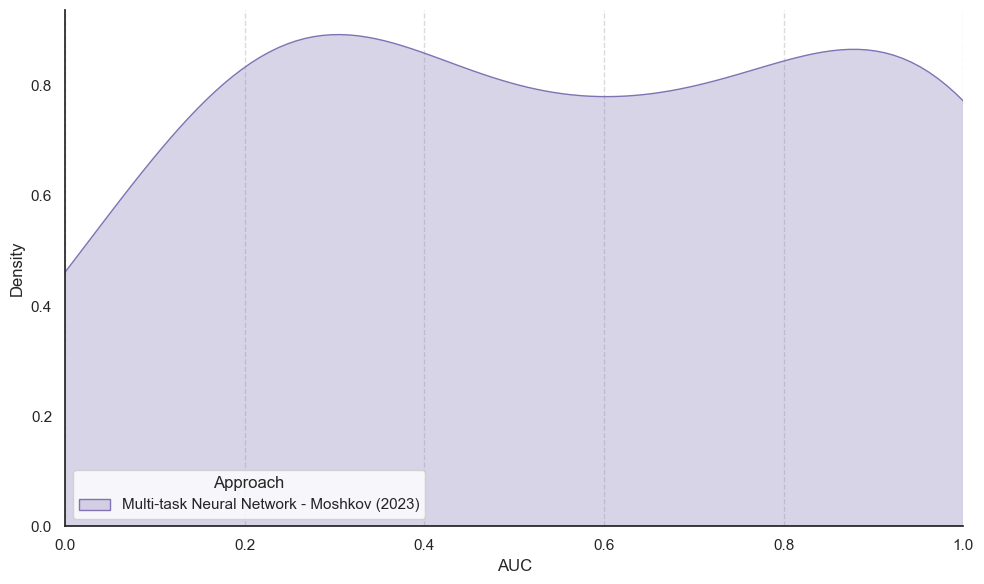

In [83]:
plot_KDE(data_excl, my_pal, "AUC", (0.0, 1.0), title=None)

# Area Under PR Gain Curve:

In [85]:
data_auprg = {
    label2: lr_adeq_assays.auprg.values,
    label3: lr_adeq_assays_cc.auprg.values,
}

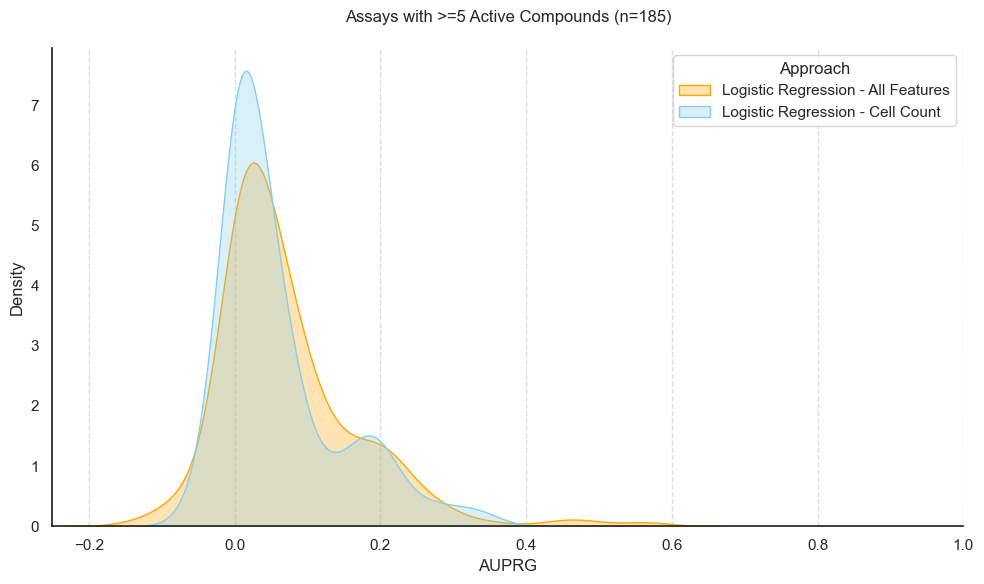

In [88]:
plot_KDE(data_auprg, my_pal, "AUPRG", (-0.25, 1.0), title="Assays with >=5 Active Compounds (n=185)\n")

In [89]:
data_auprg_ltd = {
    label2: lr_ltd_assays.auprg.values,
    label3: lr_ltd_assays_cc.auprg.values,
}

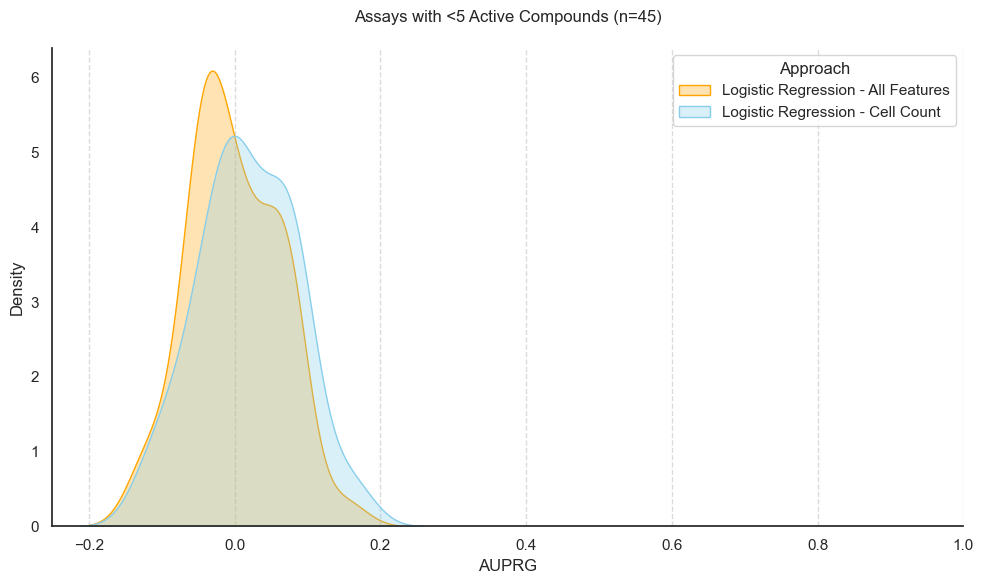

In [91]:
plot_KDE(data_auprg_ltd, my_pal, "AUPRG", (-0.25, 1.0), title="Assays with <5 Active Compounds (n=45)\n")

# Venn Diagrams Comparing Well-Predicted Assays:

In [92]:
from matplotlib_venn import venn3

In [95]:
selected_assays = all_feat_exp_metrics_df.PUMA_ASSAY_ID.unique()
len(selected_assays)

230

In [88]:
moshkov_res["descriptor"].unique()

array(['late_fusion_cs_ge', 'late_fusion_cs_ge_mobc',
       'late_fusion_cs_mobc', 'late_fusion_ge_mobc', 'cpcl_es_op',
       'cp_es_op', 'ges_es_op', 'ge_cp_es_op', 'ge_es_op',
       'ge_mobc_cp_es_op', 'ge_mobc_es_op', 'ge_mo_cp_es_op',
       'ge_mo_es_op', 'mobc_cp_es_op', 'mobc_es_op', 'mo_cp_es_op',
       'mo_es_op'], dtype=object)

In [89]:
# Select the MTNN assays predicted with AUC > 0.7:
mkov_mobc_auc_over_70 = moshkov_res[(moshkov_res["assay_id"].isin(selected_assays)) & 
                                    (moshkov_res["descriptor"]=="mobc_es_op") &
                                   (moshkov_res["auc_70"]==True)]
mkov_ge_auc_over_70 = moshkov_res[(moshkov_res["assay_id"].isin(selected_assays)) & 
                                  (moshkov_res["descriptor"]=="ge_es_op") &
                                   (moshkov_res["auc_70"]==True)]

# Select the LR model assays predicted with AUC > 0.7
lr_all_feats_over_70 = all_feat_exp_metrics_df[all_feat_exp_metrics_df["roc_auc"]>0.7]
lr_cc_feats_over_70 = mkov_splits_cc_df[mkov_splits_cc_df["roc_auc"]>0.7]

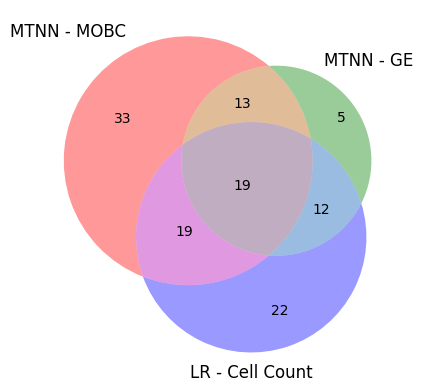

In [95]:
venn3([set(mkov_mobc_auc_over_70.assay_id.tolist()), 
       set(mkov_ge_auc_over_70.assay_id.tolist()), 
#        set(lr_all_feats_over_70.PUMA_ASSAY_ID.tolist()), 
       set(lr_cc_feats_over_70.PUMA_ASSAY_ID.tolist())], 
      ('MTNN - MOBC', 'MTNN - GE', 'LR - Cell Count')) #'LR - MOBC', 
plt.show()

# Inspecting Assays Predicted with AUC = 1.0:

- Inspecting the assays in Moshkov's original work which were predicted with AUC = 1.0.

In [151]:
import plotly.express as px

In [143]:
# How many assays predicted with AUC = 1.0, using Morphology (CellProfiler) features:
modality = "mobc_es_op"
all_assays_auc1 = len(moshkov_res[(moshkov_res["descriptor"]==modality) &
                           (moshkov_res["auc"]==1.0)])
print(f"AUC = 1.0: {all_assays_auc1}")

AUC = 1.0: 9


In [148]:
auc1_df = moshkov_res[(moshkov_res["descriptor"]==modality) & (moshkov_res["auc"]==1.0)].reset_index(drop=True)
auc1_df.rename(columns={"assay_id":"PUMA_ASSAY_ID"}, inplace=True)

# Updating df to include n. compounds and actives:
auc1_df = update_results_metrics(auc1_df, cp_assay_merged, assay_meta)

auc1_df

,PUMA_ASSAY_ID,auc,descriptor,auc_50,auc_70,auc_90,n_compounds,n_active,assay_name
0,17_28,1.0,mobc_es_op,True,True,True,51,1,BetaCateninSignaling.FluorDye.PosW2
1,175_559,1.0,mobc_es_op,True,True,True,31,1,YeastGrowthInhibition.Absorb.600
2,175_561,1.0,mobc_es_op,True,True,True,31,1,YeastGrowthInhibition.Absorb.600
3,37_77,1.0,mobc_es_op,True,True,True,34,1,CardiovascularProfiling.FluorDye.JC1Mito
4,42_104,1.0,mobc_es_op,True,True,True,31,2,CellMetabolicProfiling.Absorb.MTTStain
5,44_106,1.0,mobc_es_op,True,True,True,31,1,CellMetabolicProfiling.FluorDye.AmplexRed
6,49_149,1.0,mobc_es_op,True,True,True,35,1,CellMetabolicProfiling.FluorDye.NileRed
7,78_237,1.0,mobc_es_op,True,True,True,32,1,ErythroidSurvival.Lumin.CTG
8,9_14,1.0,mobc_es_op,True,True,True,22,1,BacterialViability.Absorb.600


In [159]:
for assay in auc1_df.PUMA_ASSAY_ID.unique():
    
    fig = px.violin(cp_assay_merged.dropna(subset=[assay]),
                    x="Cells_Number_Object_Number", 
                    color=assay,
                    box=True, points="all",
                    labels={"x": assay},
                    title=f"Assay: {assay}",
                   )

    fig.show()